In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab import files

In [2]:
uploaded = files.upload()

Saving merged_data.csv to merged_data.csv


In [3]:
# get the paths of original datasets
data_path = '/content/merged_data.csv'
log_path = '/content/merged_log_data.csv'

# load data
data_df = pd.read_csv(data_path)
log_df = pd.read_csv(log_path)

columns_with_missing_values = ['Week 3 quiz', 'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz',
       'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz', 'Week 10 quiz',
       'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
       'Week 15 quiz', 'Week 16 quiz', 'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
       'Week 7 homework', 'Week 8 homework', 'Week 9 homework',
       'Week 10 homework', 'Week 11 homework', 'Week 13 homework',
       'Week 14 homework', 'Week 15 homework']
columns_not_missing_values = ['Week 1 quiz', 'Week 2 quiz',
       'Week 3 quiz', 'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz',
       'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz', 'Week 10 quiz',
       'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
       'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
       'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
       'Week 7 homework', 'Week 8 homework', 'Week 9 homework',
       'Week 10 homework', 'Week 11 homework', 'Week 13 homework',
       'Week 14 homework', 'Week 15 homework']

columns_name_student = "Student"
columns_name_score = "Score"
columns_name_grade = "Grade"

columns_name_activity = "Activity"
columns_name_day = "Day"
columns_name_time = "Time"
add_column_activity_weeknumber = "Activity_Num"
add_column_activity_score = "Activity Score"

In [4]:
# in data_df, subsititute - with NaN in column score
data_df[columns_name_score] = data_df[columns_name_score].replace('-', np.nan)
data_df[columns_name_score] = pd.to_numeric(data_df[columns_name_score], errors='coerce')

# in data_df, delete the data that does not participate in any activity or got F due to other activtiy
# in data_df, delete the data that got A due to pre-exam
data_df = data_df.dropna(subset=[columns_name_score])
data_df = data_df.drop(data_df[(data_df[columns_name_score] > 50) & (data_df[columns_name_grade] == 'F')].index)

conditions = (data_df[columns_with_missing_values].eq(0).all(axis=1)) & (data_df[columns_name_grade] == 'A')
data_df = data_df[~conditions]

# in log_df, delete the data after ddl
log_df[columns_name_time] = pd.to_datetime(log_df[columns_name_time])
log_df[add_column_activity_weeknumber] = log_df[columns_name_activity].str.extract(r"(\d+)")
log_df[add_column_activity_weeknumber] = log_df[add_column_activity_weeknumber].astype(int)

week1 = (log_df[add_column_activity_weeknumber] == 1)
week2_16 = (log_df[add_column_activity_weeknumber] > 1) & (log_df[add_column_activity_weeknumber] <= 16)

time_start_for_week2_16 = (log_df[columns_name_time].dt.time < pd.to_datetime('18:00:00').time())
time_end_for_week2_16 = (log_df[columns_name_time].dt.time > pd.to_datetime('8:00:00').time())

invalid_for_week1 = (log_df[columns_name_day] < 1) | (log_df[columns_name_day] > 7)

invalid_start_for_week2_16 = (log_df[columns_name_day] < (7 * (log_df[add_column_activity_weeknumber] -1) - 3)) | ((log_df[columns_name_day] == (7 * (log_df[add_column_activity_weeknumber] -1) - 3)) & time_start_for_week2_16)
invalid_end_for_week2_16 = (log_df[columns_name_day] > (7 * (log_df[add_column_activity_weeknumber] -1) + 4)) | ((log_df[columns_name_day] == (7 * (log_df[add_column_activity_weeknumber] -1) + 4)) & time_end_for_week2_16)

condition1 = week1 & invalid_for_week1
condition2 = week2_16 & (invalid_start_for_week2_16 | invalid_end_for_week2_16)

log_df = log_df.drop(log_df[condition1].index)
log_df = log_df.drop(log_df[condition2].index)

log_df = log_df.drop(add_column_activity_weeknumber, axis=1)
log_df = log_df.drop(columns_name_day, axis=1)
log_df = log_df.drop(columns_name_time, axis=1)

# in log_df, detele all the data without maximum score
max_score_df = log_df.groupby([columns_name_student, columns_name_activity])[columns_name_score].max().reset_index()
log_df = log_df.merge(max_score_df, on=[columns_name_student, columns_name_activity, columns_name_score], how='inner')
log_df.drop_duplicates(subset=[columns_name_student, columns_name_activity], keep='first', inplace=True)

<ipython-input-4-0d9c07742147>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  log_df = log_df.drop(log_df[condition2].index)


In [5]:
# merge data_df and log_df based on Student and Activity
pivoted_log_df = log_df.pivot(index='Student', columns='Activity', values='Score')
pivoted_log_df.columns = [f'{col} maxscore' for col in pivoted_log_df.columns]
merged_df = data_df.merge(pivoted_log_df, left_on='Student', right_index=True, how='left')

In [6]:
data_df.to_csv('/content/data_df.csv', index=False)
files.download('/content/data_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
log_df.to_csv('/content/log_df.csv', index=False)
files.download('/content/log_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
merged_df.to_csv('/content/merged_df.csv', index=False)
files.download('/content/merged_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from sklearn.model_selection import train_test_split

# define features：the number of attempts and maximum score of each exercise
features = ['Week 1 quiz', 'Week 2 quiz', 'Week 3 quiz', 'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz',
            'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz', 'Week 10 quiz', 'Week 11 quiz', 'Week 12 quiz',
            'Week 13 quiz', 'Week 14 quiz', 'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework',
            'Week 2 homework', 'Week 3 homework', 'Week 4 homework', 'Week 5 homework', 'Week 7 homework',
            'Week 8 homework', 'Week 9 homework', 'Week 10 homework', 'Week 11 homework', 'Week 13 homework',
            'Week 14 homework', 'Week 15 homework', 'Week 1 homework maxscore', 'Week 1 quiz maxscore',
            'Week 10 homework maxscore', 'Week 10 quiz maxscore', 'Week 11 homework maxscore',
            'Week 11 quiz maxscore', 'Week 12 quiz maxscore', 'Week 13 homework maxscore',
            'Week 13 quiz maxscore', 'Week 14 homework maxscore', 'Week 14 quiz maxscore',
            'Week 15 homework maxscore', 'Week 15 quiz maxscore', 'Week 16 quiz maxscore',
            'Week 2 homework maxscore', 'Week 2 quiz maxscore', 'Week 3 homework maxscore',
            'Week 3 quiz maxscore', 'Week 4 homework maxscore', 'Week 4 quiz maxscore',
            'Week 5 homework maxscore', 'Week 5 quiz maxscore', 'Week 6 quiz maxscore',
            'Week 7 homework maxscore', 'Week 7 quiz maxscore', 'Week 8 homework maxscore',
            'Week 8 quiz maxscore', 'Week 9 homework maxscore', 'Week 9 quiz maxscore']

# define target：to predict the final course score
target = 'Score'

# dataset regularization
# split the data： 80%/20%
merged_df[features] = merged_df[features].fillna(value=0).replace('-', 0).astype(float)
merged_df[columns_name_score] = merged_df[columns_name_score].fillna(value=0).replace('-', 0).astype(float)

train_df, test_df, train_labels, test_labels = train_test_split(merged_df[features],
                                                                merged_df[target],
                                                                test_size=0.2,
                                                                random_state=42)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [24]:
forest_model = RandomForestRegressor(
    n_estimators=200,          # 增加树的数量
    max_depth=10,              # 设置最大深度
    min_samples_split=2,       # 调整最小样本拆分
    min_samples_leaf=1,        # 调整最小叶节点样本数
    max_features="sqrt",       # 特征采样
    random_state=42
)
forest_model.fit(train_df, train_labels)
forest_predictions = forest_model.predict(test_df)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df)
X_test_scaled = scaler.transform(test_df)
svm_model = SVR(
    kernel="rbf",   # 使用RBF核函数
    C=1.0,          # 调整惩罚参数C
    gamma="scale",  # 自动调整gamma，也可以设置为具体的值
    epsilon=0.1     # 调整epsilon
)
svm_model.fit(X_train_scaled, train_labels)
svm_predictions = svm_model.predict(X_test_scaled)

In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,  # 降低学习速率
    max_depth=5,         # 设置树的最大深度
    min_child_weight=1,  # 调整最小子样本拆分
    colsample_bytree=0.8,  # 列采样
    reg_alpha=0.1,        # L1正则化
    reg_lambda=0.1,       # L2正则化
    subsample=0.8,         # 子样本比例
    random_state=42
)
xgb.fit(train_df, train_labels)

y_pred = xgb.predict(test_df)

mse = mean_squared_error(test_labels, y_pred)
mae = mean_absolute_error(test_labels, y_pred)
print("XGBoost的MSE:", mse)
print("XGBoost的MAE:", mae)

XGBoost的MSE: 232.7039975575997
XGBoost的MAE: 10.866582130186018


Mean Squared Error for forest_model:  215.89506657302755 Mean Squared Error for svm_model:  654.6490133622668
Mean Absolute Error for forest_model:  10.781337961185516 Mean Absolute Error for svm_model:  15.958777156571212


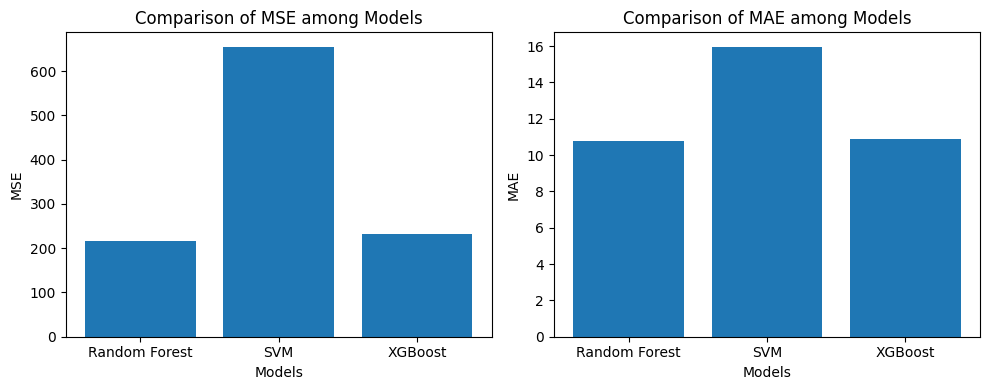

In [27]:
# Compare the effect of each model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error
forest_mse = mean_squared_error(test_labels, forest_predictions)
svm_mse = mean_squared_error(test_labels, svm_predictions)
# Mean Absolute Error
forest_mae = mean_absolute_error(test_labels, forest_predictions)
svm_mae = mean_absolute_error(test_labels, svm_predictions)
# Print the compare results
print("Mean Squared Error for forest_model: ", forest_mse, "Mean Squared Error for svm_model: ", svm_mse)
print("Mean Absolute Error for forest_model: ", forest_mae, "Mean Absolute Error for svm_model: ", svm_mae)

# Plot the compare results
import matplotlib.pyplot as plt

models = ['Random Forest', 'SVM', 'XGBoost']
mse_values = [forest_mse, svm_mse, mse]
mae_values = [forest_mae, svm_mae, mae]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].bar(models, mse_values)
axes[0].set_title('Comparison of MSE among Models')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('MSE')

axes[1].bar(models, mae_values)
axes[1].set_title('Comparison of MAE among Models')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MAE')

plt.tight_layout()
plt.show()